In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
import json
import os

In [2]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [3]:
# model_v5 = load_model(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models\monkey_tile_trained_v5')

model_best_new = load_model(r"\\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40")

model_today = load_model(r'\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_add_fallopian_test_12_7_23_lr_0.001_epochs_200_pt_40')

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5742374622613553, nms=0.3) 



base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_add_fallopian_test_12_7_23_lr_0.001_epochs_200_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5947798157959067, nms=0.3) 



In [3]:
# donald_model = load_model(r'\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\Fallopian_monkey_test_tiles_12_7_23_lr_0.001_epochs_400_pt_40')

# vasco_model = load_model(r'\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\fallopian_tube_12_7_2023_lr_0.001_epochs_400_pt_40')

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6590521771973135, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5534873561706642, nms=0.3) 



pretrain_and_monkey_f model was trained on all fallopian tube tiles we have right now minus the last tile. You should only validate its performance of the very last tile in X because it was trained on all the other tiles in X. I was just too lazy to change my code when I plot it, but this is an important note.

In [34]:
# Get tiles and labels
tiles_pth = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
masks_pth = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

not_done = ['monkey_fetus_40_0768_adrenal2.tif', 'monkey_fetus_40_0790_gonads2.tif', 'monkey_fetus_40_0844_mesokidney2.tif', 'monkey_fetus_40_1035_bone2.tif', 'monkey_fetus_40_0600_thymus2.tif', 'monkey_fetus_40_0718_lungs2.tif', 'monkey_fetus_40_0754_kidney2.tif']

tiles_pth = sorted([os.path.join(tiles_pth, pth) for pth in os.listdir(tiles_pth) if pth not in not_done and pth.endswith('.tif')])

X = tiles_pth
Y = sorted([os.path.join(masks_pth, pth) for pth in os.listdir(masks_pth) if pth.endswith('.tif.tif')])

In [35]:
print(len(X))
print(len(Y))

print(X[0])

29
29
\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles\monkey_fetus_40_0272_eyes1.tif


In [36]:
X

['\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0272_eyes1.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0273_bone.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0281_eyes2.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0308_liver1.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0323_ears1.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0344_brain1.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0380_heart1.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0381_thymus.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fetus_40_0426_lungs.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\tiles\\monkey_fet

In [37]:
X = list(map(imread,X))
Y = list(map(imread,Y))

In [38]:
X = [x/255 for x in X]  # no norm, just divide by 255 to get into (0,1) range
# Y = [fill_label_holes(y) for y in tqdm(Y)]  # fills holes in annotations if there are any

Y_pred_best = [model_best_new.predict_instances(x, n_tiles=model_best_new._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X)]

Y_pred_donald = [model_today.predict_instances(x, n_tiles=model_best_new._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X)]

# Y_pred_vasco = [vasco_model.predict_instances(x, n_tiles=model_best_new._guess_n_tiles(x), show_tile_progress=False)[0]
              # for x in tqdm(X)]

100%|██████████| 29/29 [00:01<00:00, 19.09it/s]


In [39]:
Y_pred_best[1].shape

(256, 256)

In [25]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

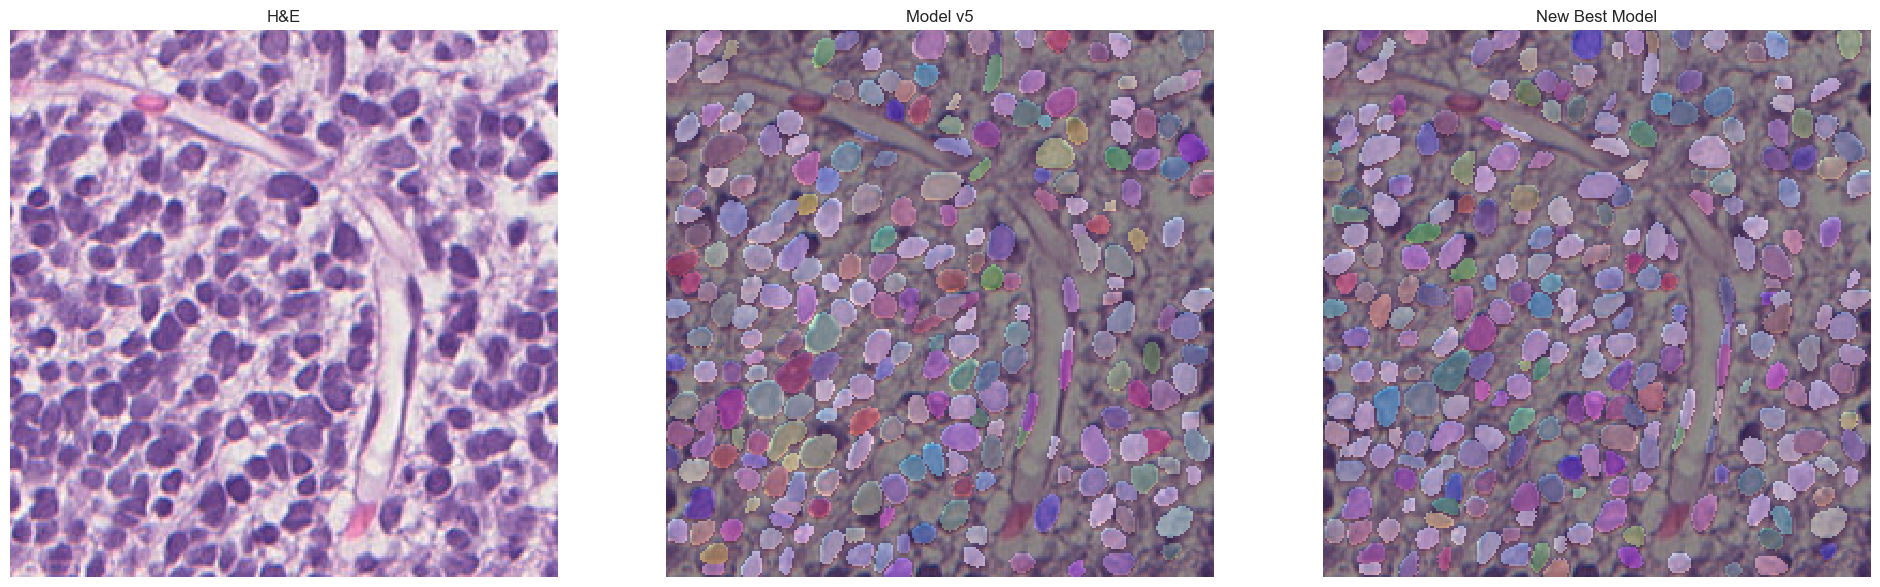

In [40]:
ind = 5

tile = X[ind]

fig, ax = plt.subplots(1,3,figsize = (24, 8))
ax[0].imshow(tile)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(tile)
ax[1].imshow(Y_pred_best[ind], cmap=lbl_cmap, alpha=0.4)
ax[1].axis('off')
ax[1].set_title('Model v5')

ax[2].imshow(tile)
ax[2].imshow(Y_pred_donald[ind], cmap=lbl_cmap, alpha=0.4)
ax[2].axis('off')
ax[2].set_title('New Best Model')
plt.show()

In [41]:
print(len(Y))

29


In [42]:
masks_pth

'\\\\10.99.68.178\\andreex\\data\\Stardist\\Testing\\monkey\\qupath\\ground_truth\\masks'

In [43]:
[nm for nm in os.listdir(masks_pth)]

['monkey_fetus_40_0272_eyes1.tif.tif',
 'monkey_fetus_40_0273_bone.tif.tif',
 'monkey_fetus_40_0281_eyes2.tif.tif',
 'monkey_fetus_40_0308_liver1.tif.tif',
 'monkey_fetus_40_0323_ears1.tif.tif',
 'monkey_fetus_40_0344_brain1.tif.tif',
 'monkey_fetus_40_0380_heart1.tif.tif',
 'monkey_fetus_40_0381_thymus.tif.tif',
 'monkey_fetus_40_0426_lungs.tif.tif',
 'monkey_fetus_40_0428_thyroid1.tif.tif',
 'monkey_fetus_40_0451_heart2.tif.tif',
 'monkey_fetus_40_0452_gi1.tif.tif',
 'monkey_fetus_40_0471_kidney.tif.tif',
 'monkey_fetus_40_0476_gi2.tif.tif',
 'monkey_fetus_40_0483_brain2.tif.tif',
 'monkey_fetus_40_0497_gi3.tif.tif',
 'monkey_fetus_40_0502_adrenal.tif.tif',
 'monkey_fetus_40_0505_mesokidney.tif.tif',
 'monkey_fetus_40_0506_brain3.tif.tif',
 'monkey_fetus_40_0508_thyroid2.tif.tif',
 'monkey_fetus_40_0526_gonads.tif.tif',
 'monkey_fetus_40_0601_ecm1.tif.tif',
 'monkey_fetus_40_0603_brain4.tif.tif',
 'monkey_fetus_40_0604_gi4.tif.tif',
 'monkey_fetus_40_0664_ecm2.tif.tif',
 'monkey_fetu

In [46]:
from scoring_for_donald import TileSetScorer
import os

taus = [0.6]

nms = [nm for nm in os.listdir(masks_pth)]
scores_old = TileSetScorer(nms, Y, Y_pred_best, taus)
scores_donald = TileSetScorer(nms, Y, Y_pred_donald, taus)
# scores_vasco = TileSetScorer(nms, Y, Y_pred_vasco, taus)

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [47]:
results = scores_old.score_set()
names = results['Image']

names = [name.split(".")[0][21:] for name in names]

for i in range(len(names)):
    if len(names[i]) > 6:
        names[i] = names[i][:5]

f1_scores = results['F1 Score']

results_donald = scores_donald.score_set()
# results_vasco = scores_vasco.score_set()

f1_scores_donald = results_donald['F1 Score']
# f1_scores_vasco = results_vasco['F1 Score']

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


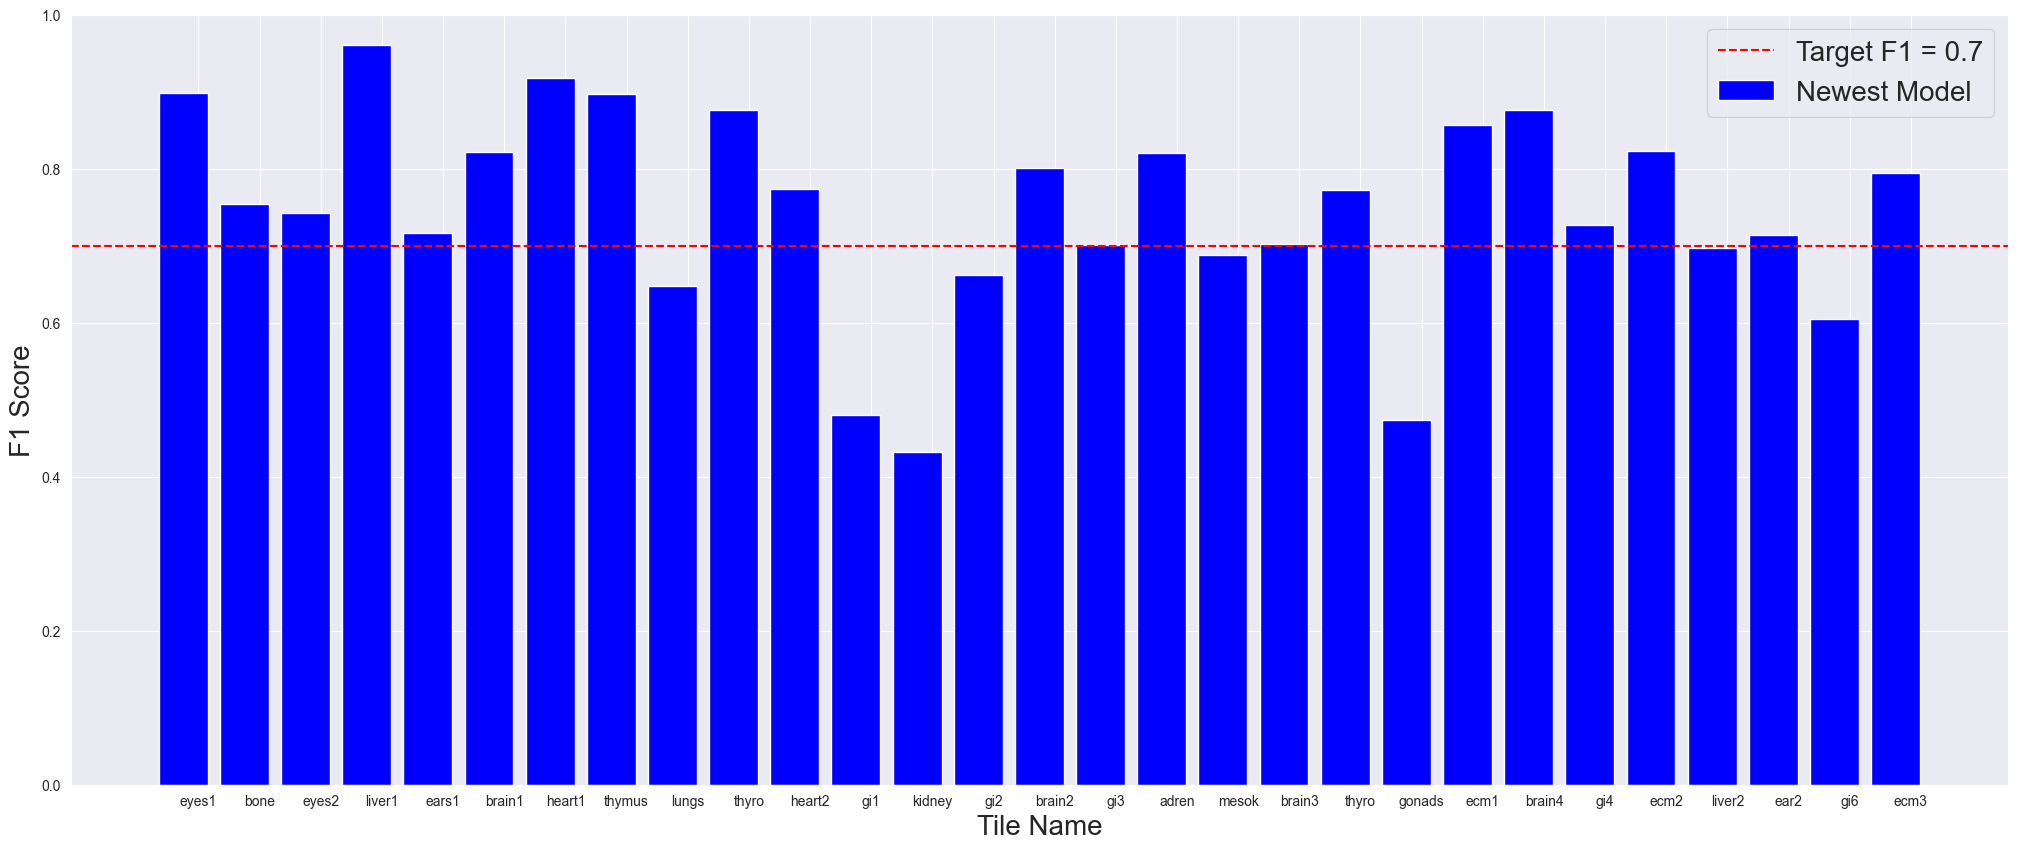

In [52]:
bar_width = 0.25  # Adjust the width of each bar as needed
index = np.arange(len(names))

# Plotting the bars
fig = plt.figure(figsize=(25, 10))
fig.set_facecolor('white')

plt.bar(index, f1_scores_donald, color='blue', label='Newest Model')

#plt.bar(index, f1_scores, color='blue', width=bar_width, label='Previous Model')
#plt.bar(index + bar_width, f1_scores_donald, color='orange', width=bar_width, label="New Validation + Fallop")
# plt.bar(index + 2 * bar_width, f1_scores_vasco, color='green', width=bar_width, label='Vasco Model')

plt.xlabel("Tile Name", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
# plt.title("F1 Scores in Testing Tiles (tau = 0.6)", fontsize=28)
plt.axhline(y=0.7, linestyle='--', color='red', label='Target F1 = 0.7')
plt.ylim(0, 1)
plt.xticks(index + bar_width, names)  # Set x-axis labels to tile names
plt.legend(fontsize=20)
plt.show()